In [1]:
import os
import sys
DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/MLQD'
path_to_file = str(DIR) + '/' + 'evolution.py'
if os.path.isfile(path_to_file):
    MLQD_DIR = DIR
else:
    MLQD_DIR = os.getcwd() + '/MLQD'
if MLQD_DIR not in sys.path:
    sys.path.append(MLQD_DIR)

In [3]:
import numpy as np
from evolution import quant_dyn
import matplotlib.pyplot as plt

We consider spin-boson model as was consider in our published study https://iopscience.iop.org/article/10.1088/1367-2630/ac3261

\begin{align} \label{eq:sb}
    \boldsymbol{\rm H} = \frac{1}{2}\epsilon \boldsymbol{\sigma}_{z}  + \frac{1}{2}\Delta \boldsymbol{\sigma}_{x} + \sum_{k} \omega_k \boldsymbol{\rm b}_k^\dagger \boldsymbol{\rm b}_k + \frac{1}{2} \boldsymbol{\sigma}_z \boldsymbol{\rm F},
\end{align}
here $\boldsymbol{\sigma}_z$ and $\boldsymbol{\sigma}_x$ are the Pauli matrices, i.e., $\boldsymbol{\sigma}_z = | e\rangle \langle e| - | g \rangle \langle g|$, $\boldsymbol{\sigma}_x =  |e\rangle \langle g| + | g \rangle \langle  e|$. $\epsilon$ and $\Delta$ are the energy bias and tunneling matrix element, respectively. $\omega_k$ is the frequency corresponds to $k$ bath mode and $\boldsymbol{\rm b}_k^\dagger$ is the corresponding bath creation operator. $\boldsymbol{\rm F}$ is the interaction operator and can be expressed as $\boldsymbol{\rm F} = \sum_k \frac{c_k}{\sqrt{2 \omega_k}} (\boldsymbol{\rm b}_k + \boldsymbol{\rm b}_k^\dagger)$, where $c_k$ denotes the coupling strength between system and $k$ bath mode. Initially, we consider that the system is in the excited state $|e\rangle$ (by absorbing a photon of energy equal to the energy gap between the two states) and we let the system to be relaxed by exchanging its energy with the bath.  

## Recursive dynamics 

In recursive dynamics, the future dynamics depends in the past dynamics 

$$ \rho(t_n) = f(t_{n-1}) $$

In some traditional quantum dynamics methods such as stochastic equation of motion (SEOM) approach, the noise in long-time dynamics deteriorates the accuracy and a good convergence needs propagation of a large number of trajectories. 

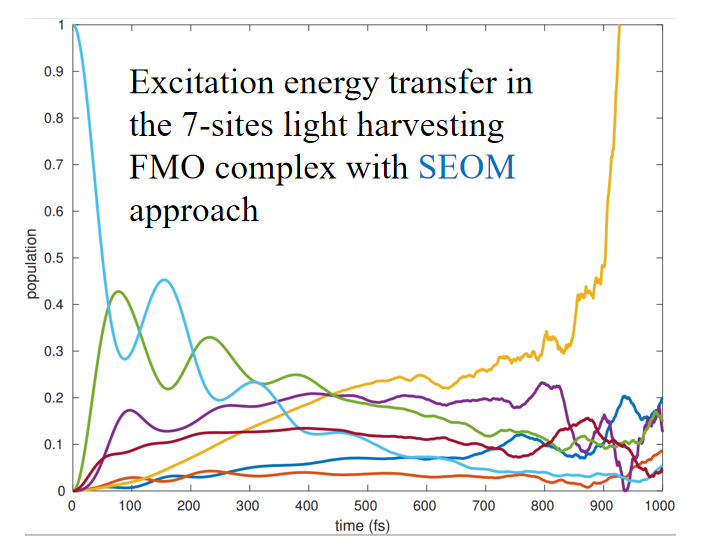


What we can do is to train a kernel ridge regression (KRR) model where if we provide a short time dynamics, the model should be able to predict the dynamics beyond it. We demonstarte this on the two-state spin-boson (SB) model. We consider the Drude–Lorentz spectral density 
$$
    J_{\text{b}}(\omega)=2 \lambda \frac{\omega \gamma}{\omega^{2}+\gamma^{2}},
$$
with $\gamma$ as characteristic frequency and $\lambda$ as the reorganization energy.

We use the Hierarchical equations of motion (HEOM) approach and generate data for all the possible combinations of the following parameters: $\epsilon = \{0, 1\}$, the reorganization energy $\lambda \in \{0.1$, $0.2$, $0.3$, $0.4$, $0.5$, $0.6$, $0.7$, $0.8$, $0.9$, $1.0 \},$ the characteristic frequency $\gamma \in \{1$, $2$, $3$, $4$, $5$, $6$, $7$, $8$, $9$, $10\},$ inverse temperature $\beta = 1/T \in \{0.1$, $0.25$, $0.5$, $0.75$, $1\}$. It should be noted that all parameters are in atomic units (a.u.). 

We generate 500 trajectories for each case (symmetric and asymmetric $\epsilon = \{0, 1\}$) and then train a KRR model on 400 trajectories (keeping 100 trajectories as a test set) for each case. You can grab the trajectories from our **QDDSET-1 dataset** [Coming Soon]. **However, here for the sake of demonstration, we provide few trajectories in the ```examples/sb_data``` folder.** We are also providing the ready made models trained on 400 trajectories for each case. [Coming Soon]

## Preparation of the training data

Each trajectory is propagated for t= 20 (a.u.) with the time-step 0.05. For training, you can also use a larger time-step t = 0.1 to minize the cost of training. We take the intial dynamics of time-length $t_m$ from each trajectory and then use it an input to predict the dynamics at the next time-step $t_{m+1}$. We include the dynamics at $t_{m-1}$ in the input short-time trajectory (dropping the value at $t_0$ to keep the length of the input the same) and then predict the dynamics at $t_{m+2}$. This process last tills the last time-step. 


![image%20%281%29.png](attachment:image%20%281%29.png)
    
            (Copyright: IOP Publishing https://iopscience.iop.org/article/10.1088/1367-2630/ac3261)
    
    
    

# Training a KRR model  

### 1. With preparation of training data and optimization of the KRR model. MLQD is using MLatom package in the backend

Kernel ridge regression (KRR) model approximates a function $f( \boldsymbol{u})$ which is defined as
$$ 
    f(\boldsymbol{u}) = \sum_{i=1}^{N_{\rm tr}} \alpha_i k\left(  \boldsymbol{u}, \boldsymbol{u}_i\right),
$$
where $ \boldsymbol{\alpha} = \{\alpha_i\}$ is a vector of regression coefficients $\alpha_i$.

We use the Gaussian kernel here 

$$
    k\left(\boldsymbol{u}, \boldsymbol{u}_{i}\right)=\exp \left(-\frac{\left\|\boldsymbol{u}-\boldsymbol{u}_{i}\right\|_{2}^{2}}{2 \sigma^{2}}\right) .
$$
To train a KRR model, we use MLatom package (http://mlatom.com/) in the backend.

For the sake of demonstration, we will use the few trajectories provided in the ```examples/sb_data``` folder. Here we take short trajectory of time-length $t_m = 4.0$ (a.u.) as an input-length. In MLQD, we pass it as ```'xlength': 81```.

In [4]:
param={ 
        'QDmodel': 'createQDmodel',     # str: create QD model. The dafault option is useQDmodel
        'QDmodelType': 'KRR',           # str: The type of model. Here KRR and the default option is OSTL
        'prepInput' : True,             # str: Prepare input files from the data (Default False)
        'XfileIn': 'x_train',           # str: (Optional, txt file) The prepared X file will be saved at the provided file name 
        'YfileIn': 'y_train',           # str: (Optional, txt file) The prepared Y file will be saved at the provided file name
        'dataPath': 'sb_data/' ,        # str: Data path
        'dataCol': 1,                   # int: Default is 1, we may have multiple columns in our data files, mention a single column (KRR model works only for single output)
        'dtype': 'real',                # str: Default is real. If the data in complex and if we pass 'real', it will prepare data only for real part and if we pass 'imag' is mentioned, only imaginary data will be considered. 
        'xlength': 81,                  # int:  Default is 81. Length of the short trajectory which will be used as an input
        'hyperParam': True,             # bool: Default is False, we can pass True (optimize the hyperparameters) or False (don't optimize and run with the default values)
        'systemType': 'SB',             # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'QDmodelOut': 'KRR_SB_model'    # str: (Optional), providing a name to save the model at
        }
quant_dyn(**param)

*****************************************
The MLQD is running with the option QDmodel =  createQDmodel
Setting ML Model Type "MLmodelType" to KRR
Setting "systemType" to SB
Setting option "prepInput" to True
MLQD Model will be saved as KRR_SB_model
Xfilein is x_train
YfileIn is y_train
You have chosen to optimize the hyper parameters of the model
MLQD is grabbing column # 1 as was passed through "dataCol"
data type "dtype" is  real
Setting length of each row in input file "xlength" to 81
*****************************************
train_ml.KRR: preparing training data for KRR model
*****************************************
prep_input.KRR: Grabbing data from " sb_data/ " directory
prep_input.KRR: Number of trajectories = 20
prep_input.KRR: The input and target values are saved as (txt files), i.e., x_train and y_train ,respectively
*****************************************
Train_ml.KRR: Training KRR model with Gaussian kernel using MLatom in the backend ......
Train_ml.KRR: KRR model will


### 2. With preparation of training data but No optimization of the KRR model. 


In [5]:
param={ 
        'QDmodel': 'createQDmodel',     # str: create QD model. The dafault option is useQDmodel
        'QDmodelType': 'KRR',           # str: The type of model. Here KRR and the default option is OSTL
        'prepInput' : True,             # str: Prepare input files from the data (Default False)
        'XfileIn': 'x_train',           # str: (Optional, txt file) The prepared X file will be saved at the provided file name 
        'YfileIn': 'y_train',           # str: (Optional, txt file) The prepared Y file will be saved at the provided file name
        'dataPath': 'sb_data/' ,        # str: Data path
        'dataCol': 1,                   # int: Default is 1, we may have multiple columns in our data files, mention a single column (KRR model works only for single output)
        'dtype': 'real',                # str: Default is real. If the data in complex and if we pass 'real', it will prepare data only for real part and if we pass 'imag' is mentioned, only imaginary data will be considered. 
        'xlength': 81,                  # int:  Default is 81. Length of the short trajectory which will be used as an input
        'hyperParam': False,            # bool: Default is False, we can pass True (optimize the hyperparameters) or False (don't optimize and run with the default values)
        'krrSigma': 4.0,                # float: If you pass False to hyperParam, then we need to provide a value for hyperparameter Sigma in Gaussian kernel. Otherwise the model will run with the default value. 
        'krrLamb': 0.00000001,          # float: If you pass False to hyperParam, then we need to provide a value for hyper parameter Lambda in KRR. Otherwise the model will run with the default value.
        'systemType': 'SB',             # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'QDmodelOut': 'KRR_SB_model'    # str: (Optional), providing a name to save the model at
        }
quant_dyn(**param)

*****************************************
The MLQD is running with the option QDmodel =  createQDmodel
Setting ML Model Type "MLmodelType" to KRR
Setting "systemType" to SB
Setting option "prepInput" to True
MLQD Model will be saved as KRR_SB_model
Xfilein is x_train
YfileIn is y_train
You have chosen not to optimize the hyper parameters of the model
MLQD is grabbing column # 1 as was passed through "dataCol"
data type "dtype" is  real
Setting length of each row in input file "xlength" to 81
Setting hyperparameter Sigma for Guassian kernel "krrSigma" to  4.0
Setting hyperparameter Lambda for KRR "krrLamb" to  1e-08
*****************************************
train_ml.KRR: preparing training data for KRR model
*****************************************
prep_input.KRR: Grabbing data from " sb_data/ " directory
prep_input.KRR: Number of trajectories = 20
prep_input.KRR: The input and target values are saved as (txt files), i.e., x_train and y_train ,respectively
*****************************

### 3. Without preparation of training data and optimization of the KRR model. 

In this example, we will not prepare the training data and will directly pass the X and Y files as were prepared in demonstration 1 or 2 

In [7]:
param={ 
        'QDmodel': 'createQDmodel',     # str: create QD model. The dafault option is useQDmodel
        'QDmodelType': 'KRR',           # str: The type of model. Here KRR and the default option is OSTL
        'prepInput' : False,             # str: Prepare input files from the data (Default False)
        'XfileIn': 'x_train',           # str: (Optional, txt file) The prepared X file will be saved at the provided file name 
        'YfileIn': 'y_train',           # str: (Optional, txt file) The prepared Y file will be saved at the provided file name
        'hyperParam': False,            # bool: Default is False, we can pass True (optimize the hyperparameters) or False (don't optimize and run with the default values)
        'krrSigma': 4.0,                # float: If you pass False to hyperParam, then we need to provide a value for hyperparameter Sigma in Gaussian kernel. Otherwise the model will run with the default value. 
        'krrLamb': 0.00000001,          # float: If you pass False to hyperParam, then we need to provide a value for hyper parameter Lambda in KRR. Otherwise the model will run with the default value.
        'systemType': 'SB',             # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'QDmodelOut': 'KRR_SB_model'    # str: (Optional), providing a name to save the model at
        }
quant_dyn(**param)

*****************************************
The MLQD is running with the option QDmodel =  createQDmodel
Setting ML Model Type "MLmodelType" to KRR
Setting "systemType" to SB
Setting option "prepInput" to False
MLQD Model will be saved as KRR_SB_model
Xfilein is x_train
YfileIn is y_train
You have chosen not to optimize the hyper parameters of the model
Setting data column "dataCol" to default value  1
Setting data type "dtype" to default type  real
Setting length of x-input "xlength" to default value 81
Setting hyperparameter Sigma for Guassian kernel "krrSigma" to  4.0
Setting hyperparameter Lambda for KRR "krrLamb" to  1e-08
*****************************************
*****************************************
Train_ml.KRR: Training KRR model with Gaussian kernel using MLatom in the backend ......
Train_ml.KRR: KRR model will be created and saved as "KRR_SB_model"
Train_ml.KRR: Checking to see whether the input data files x_train and y_train exists
***************************************

# Propagating dynamics with the trained KRR model 

Lets propagate dynamics with the above trained KRR model trained on site-1 population. We provide a test file ```site_1_pop.txt``` in ```example/test_set/sb/``` having an unseen short time trajectory (of the same length as was adopted during the training). We feed this short-time dynamics to the trained KRR model and we hope that it will predict the long dynamics. The short-time trajectoy is passed as a txt file.

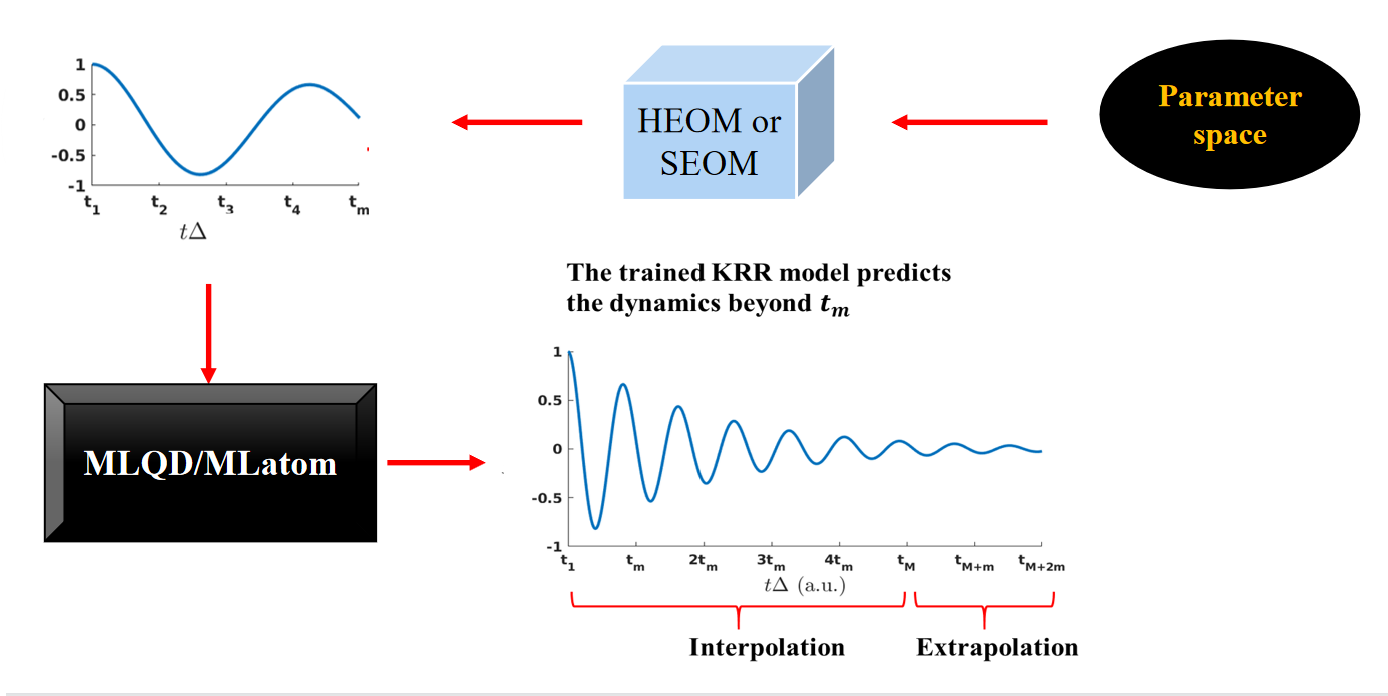


In [8]:
param={ 
        'time': 20,                     # float: Propagation time in picoseconds (ps) for FMO complex and in (a.u.) for spin-boson model
        'time_step': 0.05,              # float: Time-step for time-propagation (you are restricted to the time-step used in the training data). Default for KRR is 0.1
        'QDmodel': 'useQDmodel',        # str: In MLQD, the dafault option is useQDmodel tells the MLQD to propagate dynamics with an existing trained model
        'QDmodelType': 'KRR',           # str: The type of model we wanna use (KRR, AIQD, or OSTL). Here KRR and the default option is OSTL
        'XfileIn': 'test_set/sb/state_1_pop.txt',           # str: Name of a txt file where a short time trajectory (equal to the length the input-model was trained on) is saved. The data should be row wise.
        'systemType': 'SB',             # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'QDmodelIn': 'KRR_SB_model',    # str: (Not optional for useQDmodel), provide the name of the trained ML model
        'QDtrajOut': 'KRR_trajectory'    # str: (Optional), File name where the trajectory should be saved
 }
quant_dyn(**param)

*****************************************
The MLQD is running with the option QDmodel =  useQDmodel
Setting ML Model Type "QDmodelType" to KRR
Setting "systemType" to SB
Setting propagation time "time" to 20
Setting time_step to 0.05
Using the trained model "KRR_SB_model" for dynamics prediction
Reading from the input file XfileIn "test_set/sb/state_1_pop.txt" ..........
*****************************************
KRR_SB_model
ml_dyn.KRR: Running dynamics with KRR model using MLatom in the backend ......
ml_dyn.KRR: The output of MLatom will be saved as "kkr_dyn_output"
ml_dyn.KRR: Dynamics is saved in a file  "KRR_trajectory"
ml_dyn.KRR: Time taken = 635.6422941684723 sec


Text(0.5, 1.0, 'Time evolution of the excited state \n population in the spin-boson model')

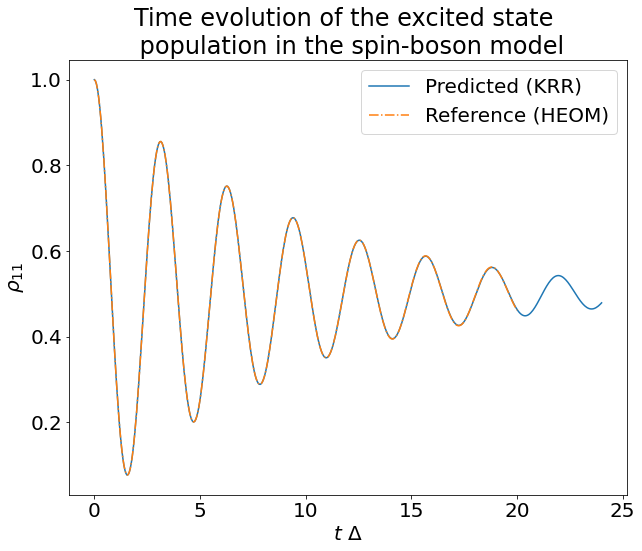

In [47]:
heom_dyn = np.load('test_set/sb/2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-4.0_beta-1.0.npy')
pred_dyn = np.load('KRR_trajectory.npy')
t_1 = np.real(heom_dyn[:,0])
t_2 = pred_dyn[:,0]
pred_state_1_pop = pred_dyn[:,1]
heom_state_1_pop = np.real(heom_dyn[:,1])

plt.rcParams['font.size'] = '20'
plt.figure(figsize=(10,8))
plt.plot(t_2, pred_state_1_pop, )
plt.plot(t_1, heom_state_1_pop, '-.')
plt.xlabel(r'$t \ \Delta$')
plt.ylabel(r'$\rho_{11}$')
plt.legend(["Predicted (KRR)", 'Reference (HEOM)'])
plt.title('Time evolution of the excited state \n population in the spin-boson model')

We can see that by providing a shot-time dynamics of 4 (a.u), the KRR model was able to predict the beyond dynamics and suprisingly, it could also extrapolate beyond the training region as shown by the blue region at the end. 